# Topic Modeling for Jeopardy Questions
by Amee Tan & Michelle JanneyCoyle

### Outline
0. Data cleaning
1. Determine optimal K using coherence score <br> 
    1.1 How does the optimal K for each year relate to the number of Jeopardy questions that year? <br> 
2. EDA - Number of questions by decade <br>
3. Topic Modeling Approach 1: LDA <br> 
    3.1 LDA Modeling Steps <br>
    3.2 Trends in each round by decade <br>
        - 3.2.1 Trends in the top Jeopardy terms by decade 
        - 3.2.2 Trends in the top Double Jeopardy terms by decade 
        - 3.2.3 Trends in the top Final Jeopardy terms by decade 
        - 3.2.4 Variation of topics in the 3 rounds 
4. Topic Modeling Approach 2: NMF <br>
    4.1 NMF Modeling Steps <br>
    4.2 Exploring Topic Meaning Over Time - with NMF  <br> 
        - 4.2.1 How similar are topic questions over time?  
        - 4.2.2 How do the actual topics of the questions change over the years?  

In [149]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import spacy 

from matplotlib.patches import Rectangle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from textpipe import doc
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# For coherence score
import gensim
from gensim import corpora
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.nmf import Nmf

# 0. Data Cleaning
## Step 1: 
1. Tokenizing
2. Lemmatizing 
3. Removing stop words and punctuation 

In [309]:
nlp = spacy.load("en_core_web_sm") 
all_stopwords = nlp.Defaults.stop_words

def question_answer_cleaning(row): 
    # removing html 
    document = doc.Doc(row).clean
    document = nlp(document)
    final_doc = ""
    for token in document:
        # lemmatizing 
        lemmatized_token = token.lemma_
        # removing stop words and punctuation 
        if (lemmatized_token not in all_stopwords) and (token.is_punct == False) and (token.like_num == False):
            final_doc += " " + str.lower(lemmatized_token)
    return final_doc

In [ ]:
data = pd.read_json("JEOPARDY_QUESTIONS1.json")

In [329]:
data['answer'] = data.apply(lambda row: question_answer_cleaning(row['answer']), axis=1)
data['question'] = data.apply(lambda row: question_answer_cleaning(row['answer']), axis=1)

In [330]:
def remove_punct(word):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for ele in word: 
        if ele in punc: 
            word = word.replace(ele, "") 
    return word

In [332]:
# to date 
data['air_date'] = pd.to_datetime(data['air_date'])

# cleaning value column 
def value_clean(row):
    if row:
        return int(row.strip('$').replace(",", ""))
    else: # some missing 
        return row 
data['value'] = data.apply(lambda row: value_clean(row['value']), axis=1)

In [335]:
data['answer'] = data.apply(lambda row: remove_punct(str(row['answer'])), axis=1)
data['question'] = data.apply(lambda row: remove_punct(str(row['question'])), axis=1)

## Step 2: Add columns for years, decades

In [1]:
# changing to datetime
data['air_date'] = pd.to_datetime(data['air_date'])
# adding decade
data['decade'] = data.apply(lambda row: (row['air_date'].year // 10)*10, axis=1)
# year
data['year'] = data.apply(lambda row: row['air_date'].year, axis=1)
# month
data['month'] = pd.to_datetime(data['air_date'], format='%Y-%m-%d').dt.month

In [393]:
data.head(2)

,category,air_date,question,value,answer,round,show_number,decade,month,year
0,HISTORY,2004-12-31,year life galileo house arrest espouse man th...,200.0,copernicus,Jeopardy!,4680,2000,12,2004
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,olympian football star carlisle indian school...,200.0,jim thorpe,Jeopardy!,4680,2000,12,2004


## Step 3: Joining question and answer columns 

In [444]:
def combineQA(row):
    final_str = ''
    if row['question']:
        final_str += str(row['question'])
    if row['answer']:
        final_str += str(row['answer'])
    if final_str != '':
        return final_str
    else: return None
data['Q_and_A'] = data.apply(lambda row: combineQA(row), axis=1)

# 1. Determine optimal K using coherence score

To determine the optimal number of topics within a given year and/or game type (i.e. Jeopardy!, Double Jeopardy!, or Final Jeopardy!) we decided to find the coherence scores of each topic. At its most basic level the coherence score measures the intra-topic distance between words. Therefore, topics with smaller coherence scores are "better" than topics with larger coherence scores. 

In [ ]:
# Function based on the following tutorial: 
# https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

def optimal_categories(data, year):
    # limiting the year 
    data_year = data[data['year'] == year]

    game_types = ["Jeopardy!", "Double Jeopardy!", "Final Jeopardy!"]
    optimal_categories = []
    for g_type in game_types:
        # limiting to each of the categories we are exploring 
        data_category = data_year[data_year['round'] == g_type]
        
        # Use Gensim's NMF to get the best num of topics via coherence score
        texts_category = data_category['Q_and_A_list']
        dictionary = corpora.Dictionary(texts_category)
        # Filter out extremes to limit the number of features
        dictionary.filter_extremes(
            no_below=3,
            no_above=0.90, # trying 90 just for funzies 
            keep_n=5000
        )
        # Create the bag-of-words format (list of (token_id, token_count))
        corpus = [dictionary.doc2bow(text) for text in texts_category]
        # Create a list of the topic numbers to try
        topic_nums = list(np.arange(10, 90 + 1, 5))
        
        coherence_scores = []
        for num in topic_nums:
            nmf = Nmf(
                corpus=corpus,
                num_topics=num,
                id2word=dictionary,
                chunksize=2000,
                passes=5,
                kappa=.1,
                minimum_probability=0.01,
                w_max_iter=100,
                w_stop_condition=0.0001,
                h_max_iter=50,
                h_stop_condition=0.001,
                eval_every=10,
                normalize=True)

            # Run the coherence model to get the score
            cm = CoherenceModel(
                model=nmf,
                texts=texts_category,
                dictionary=dictionary,
                coherence='c_v')

            coherence_scores.append(round(cm.get_coherence(), 5))
        scores = list(zip(topic_nums, coherence_scores))
        scores.sort(key = lambda x: x[1])
        max_score = scores[-1]
        optimal_categories.append((g_type, max_score))
    return optimal_categories

In [ ]:
# running function for all years so we can find optimal number of categories for each year 
years = list(set(data['year'].values))
yearly_optimal_categories = []
for year in years:
    yearly_optimal_categories.append(optimal_categories(data, year))

In [ ]:
df_optimal_k = pd.DataFrame(yearly_optimal_categories)

In [11]:
df_optimal_j = df_optimal_k.copy()[['0']]
df_optimal_dj = df_optimal_k.copy()[['1']]
df_optimal_fj = df_optimal_k.copy()[['2']]

In [22]:
def prepare_optimal_categories_df(df, col_name):
    df['K'] = df[col_name].apply(lambda x: x.rpartition("(")[2])
    df['K'] = df['K'].apply(lambda x: x.partition(",")[0]).astype(int) 
    df['year'] = np.arange(1984, 2012)
    df['decade'] = df.apply(lambda row: (row['year'] // 10)*10, axis=1)
    return df

In [23]:
df_opt_j = prepare_optimal_categories_df(df_optimal_j, '0')
df_opt_dj = prepare_optimal_categories_df(df_optimal_dj, '1')
df_opt_fj = prepare_optimal_categories_df(df_optimal_fj, '2')

In [184]:
jeopardy= data.loc[data['round']=='Jeopardy!']
dj = data.loc[data['round']=='Double Jeopardy!']
fj = data.loc[data['round']=='Final Jeopardy!']

In [14]:
def create_yearly_counts_df(df):
    df_yearly_counts = df['year'].value_counts().to_frame().reset_index()
    df_yearly_counts.rename(columns={'year':'num_questions','index':'year'}, inplace=True)
    df_yearly_counts = df_yearly_counts.sort_values('year')
    return df_yearly_counts

In [17]:
j_yearly_counts = create_yearly_counts_df(jeopardy)
dj_yearly_counts = create_yearly_counts_df(dj)
fj_yearly_counts = create_yearly_counts_df(fj)

In [19]:
def plot_questions_vs_optimal_categories(df_yearly_counts, df_opt, jeopardy_round):
    ax = df_yearly_counts.plot(x="year", y="num_questions", legend=False)
    ax2 = ax.twinx()
    df_opt.plot(x="year", y="K", ax=ax2, legend=False, color="r")
    ax.figure.legend(bbox_to_anchor=(0.4, -0.2, 0.5, 0.5))
    ax.set_title(f"Optimal K is related to number of {jeopardy_round} questions")
    ax.set_ylabel("Number of Questions")
    ax2.set_ylabel("K Categories")
    plt.show()


## 1.1 How does the optimal K for each year relate to the number of Jeopardy questions that year?
After calculating the optimal K for each year, we noticed there was a wide range of K. We were curious to see what was driving the differences year to year and plotted the optimal K against the number of questions in the corpus for that year. Turns out the two were pretty closely related for all 3 round of Jeopardy. 

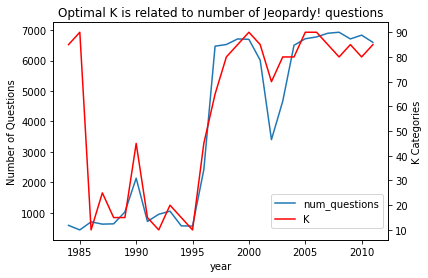

In [20]:
plot_questions_vs_optimal_categories(j_yearly_counts, df_opt_j, "Jeopardy!")

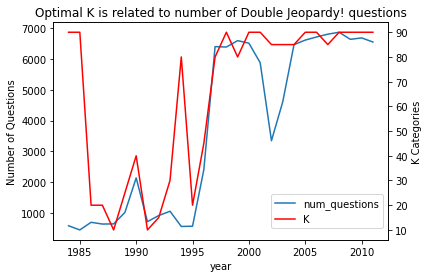

In [24]:
plot_questions_vs_optimal_categories(dj_yearly_counts, df_opt_dj, "Double Jeopardy!")

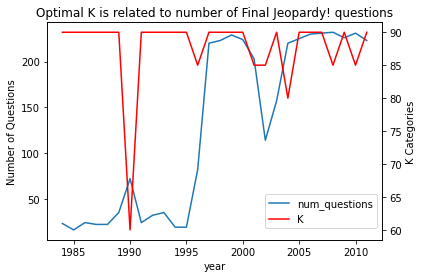

In [25]:
plot_questions_vs_optimal_categories(fj_yearly_counts, df_opt_fj, "Final Jeopardy!")

# 2. EDA - Number of questions by decade  
Before we started analyzing topics, we wanted to further understand the data that we were working with. In the plot below, we have visualized the number of questions in the corpus, broken down by Jeopardy round and decade. There are 3 important things to note:
- The corpus starts with questions from 1984, so the 1980s decade contains questions for only 6 years 
- The corpus ends with questions in 2011, so the 2010s decade only contains questions for 2 years. This is why its bars are so much shorter than the 2000s decade
- There are much fewer Final Jeopardy questions than Jeopardy and Double Jeopardy questions since each show has only one Final Jeopardy question but 30 Jeopardy and 30 Double Jeopardy questions per show.

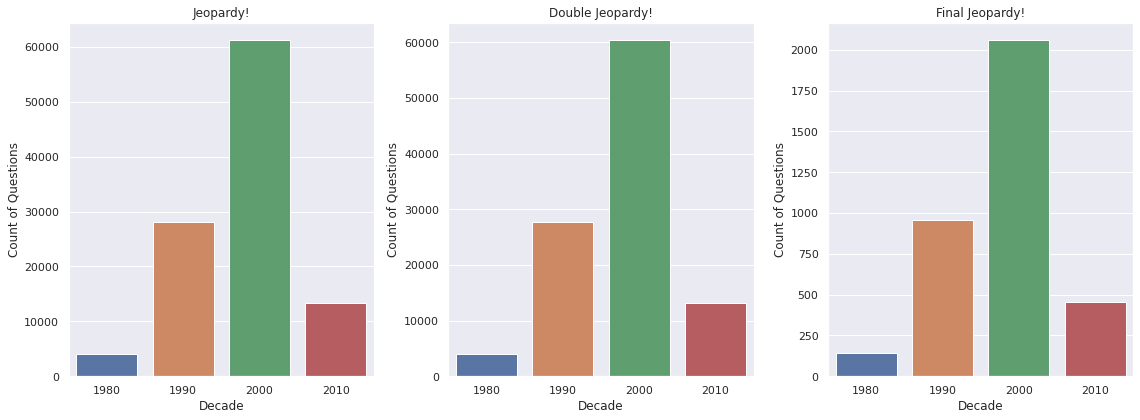

In [283]:
df1_counts = jeopardy['decade'].value_counts().to_frame().reset_index().sort_values("index")
df2_counts = dj['decade'].value_counts().to_frame().reset_index().sort_values("index")
df3_counts = fj['decade'].value_counts().to_frame().reset_index().sort_values("index")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
axes = axes.flatten()

df_counts = [df1_counts, df2_counts, df3_counts]

for i, df in enumerate(df_counts):
    sns.barplot(x='index', y='decade', data=df, ax =axes[i])
    axes[i].set_ylabel("Count of Questions")
    axes[i].set_xlabel("Decade")

axes[0].set_title("Jeopardy!")
axes[1].set_title("Double Jeopardy!")
axes[2].set_title("Final Jeopardy!")

plt.tight_layout()
plt.show()

# Two topic modeling approaches: LDA and NMF 

For our analysis we decided to break it down into two major analyses. The first done with on LDA and the second done with NMF. For both analyses we first determined the optimal number of topics following the steps outlined below. With NMF we looked at the annual trends for all rounds grouped together. In this analysis, each topic was described with 10 words. With LDA we looked at trends within each round (Jeopardy, Double Jeopardy, Final Jeopardy) by decade. In this analysis, each topic was described with 3 words. 

Overall, identifying trends over time and across Jeopardy! segments was a challenging task. Attempting to understand what identified topics signify (either with 3 or 10 top words, or hand coded topics) is more of a creative than technical venture. Nevertheless, we did uncover some interesting insights. For example, we found that topics generally overlap by roughly 13% from year to year (see NMF section 4.2.1 for more details). Additionally, we found that Final Jeopardy questions were more similar over the decades than the other Jeopardy rounds (see LDA section 3.2.4 for more details). More questions and answers are explored in the following setions.    

# 3. Topic Modeling Approach 1 : LDA


## 3.1 LDA Modeling Steps
We wrote a function that uses LDA to return the top n topics for a given Jeopardy round for a given decade. Each topic can be described by the top m words. We found the mean optimal number of components for each decade and used this as the number of components when fitting the LDA model. Then, we used the alphas to determine which topics were most important to the corpus. 

In our analysis, we found the top 10 topics per decade and describe each of those topics using the top 3 most important words (by finding the terms with the highest betas for each topic). 

In [180]:
def top_n_topics(n, decade, words_per_topic, jeopardy_round, df_opt):
    """ This functions returns the top n most important topics to the corpus. 
    words_per_topic allows you to specify how many words you want to define a topic"""
    
    # 1. Create TFIDF Matrix
    tfidf_vectorizer = TfidfVectorizer(
        min_df=3, # include only words that appear in at least 3 questions
        max_df=0.85, # exclude words that appear in 85% or more of the documents 
        max_features=2000)
    
    tf = tfidf_vectorizer.fit_transform(list(jeopardy_round['Q_and_A'].loc[jeopardy_round['decade']==decade]))

    n_components = int(df_opt.loc[df_opt['decade']==decade].mean()['K']) # mean optimal K for the given decade 

    
    # 2. Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_components, 
                                learning_method='online',
                                random_state=0)
    lda.fit(tf)
    
    # 3. Shows the prevelence of each question for each topic
    res = lda.fit_transform(tf) # shape =(num questions, num topics)
    
    # 4. Calculate topic importance (alpha) by summing each column of res --> these are the alphas
    topic_importance = np.sum(res, axis=0) # shape = (num topics, )
    
    # 5. Create a list of tuples that show (topic number, "prevelence score")
    topimp = []

    for i,t in enumerate(topic_importance):
        topimp.append((i,t))

    topimp = sorted(topimp, key=lambda x: x[1], reverse=True)
    
    # 6. lda.components_ shows the prevalence of each term in the category
    # For each row, find the 3 largest numbers, return that col numbers, look up those numbers in feature_names
    
    def return_idx_of_largest_n(myArray, n):
        idx_array = []
        for row in myArray:
            idx = []
            sorted_row_values = sorted(row, reverse=True)[:n]
            for value in sorted_row_values:
                idx.append(np.where(row==value)[0][0])
            idx_array.append(idx)

        return np.array(idx_array)
    
    idx = return_idx_of_largest_n(lda.components_, words_per_topic)    

    # 7. Create a mapping between each topic and the top word for that topic 

    feature_names= tfidf_vectorizer.get_feature_names() 


    top_words_per_category = []
    topic = 0
    for row in idx:
        row_words = []
        for x in row:
            row_words.append(feature_names[x])
        top_words_per_category.append((topic,row_words))
        topic += 1
                
    # 8. Return the names of the top 10 topics 
    top_n = [x[0] for x in topimp[:n]]

    top_n_topics_list = []
    for topic in top_words_per_category:
        if topic[0] in top_n:
            top_n_topics_list.append(topic[1])
    
    return top_n_topics_list

In [115]:
# Jeopardy Topics --> Returns a list of the top 3 words for each topic 
topics_1980 = top_n_topics(10, 1980, 3, jeopardy, df_opt_j)
topics_1990 = top_n_topics(10, 1990, 3, jeopardy, df_opt_j)
topics_2000 = top_n_topics(10, 2000, 3, jeopardy, df_opt_j)
topics_2010 = top_n_topics(10, 2010, 3, jeopardy, df_opt_j)

In [188]:
# Double Jeopardy Topics
dj_topics_1980 = top_n_topics(10, 1980, 3, dj, df_opt_dj)
dj_topics_1990 = top_n_topics(10, 1990, 3, dj, df_opt_dj)
dj_topics_2000 = top_n_topics(10, 2000, 3, dj, df_opt_dj)
dj_topics_2010 = top_n_topics(10, 2010, 3, dj, df_opt_dj)

In [191]:
# Final Jeopardy Topics
fj_topics_1980 = top_n_topics(10, 1980, 3, fj, df_opt_fj)
fj_topics_1990 = top_n_topics(10, 1990, 3, fj, df_opt_fj)
fj_topics_2000 = top_n_topics(10, 2000, 3, fj, df_opt_fj)
fj_topics_2010 = top_n_topics(10, 2010, 3, fj, df_opt_fj)

### Example of top 10 topics
Below is an example of the output of the function. This shows the top 10 topics for Final Jeopardy in the 2000s. Each topic is represented by the top 3 words for that topic. 

In [204]:
fj_topics_2000

[['city', 'capital', 'team'],
 ['state', 'new', 'us'],
 ['president', 'castle', 'catherine'],
 ['year', 'begin', 'bear'],
 ['nation', 'country', 'note'],
 ['century', 'man', 'home'],
 ['come', 'word', 'letter'],
 ['history', 'sport', 'river'],
 ['large', 'europe', 'country'],
 ['win', 'oscar', 'good']]

In [215]:
def flatten_decade(topics_decade):
    flat_decade = []
    for row in topics_decade:
        for topic in row:
            flat_decade.append(topic)
    return list(set(flat_decade))


In [216]:
flat_1980 = flatten_decade(topics_1980)
flat_1990 = flatten_decade(topics_1990)
flat_2000 = flatten_decade(topics_2000)
flat_2010 = flatten_decade(topics_2010)


In [217]:
# Double Jeopardy
dj_flat_1980 = flatten_decade(dj_topics_1980)
dj_flat_1990 = flatten_decade(dj_topics_1990)
dj_flat_2000 = flatten_decade(dj_topics_2000)
dj_flat_2010 = flatten_decade(dj_topics_2010)

# Final Jeopardy
fj_flat_1980 = flatten_decade(fj_topics_1980)
fj_flat_1990 = flatten_decade(fj_topics_1990)
fj_flat_2000 = flatten_decade(fj_topics_2000)
fj_flat_2010 = flatten_decade(fj_topics_2010)

In [219]:
def create_topic_count_list(flat1, flat2, flat3, flat4):

    flat_all_topics = flat1 + flat2 + flat3 + flat4 

    topic_count = {}

    for topic in flat_all_topics:
        topic_count[topic] = topic_count.get(topic,0) +1

    topic_count_list = [(k,v) for k, v in sorted(topic_count.items(), key=lambda item: item[1], reverse=True)]
    
    return topic_count_list

In [223]:
j_topic_count_list = create_topic_count_list(flat_1980, flat_1990, flat_2000, flat_2010)
dj_topic_count_list = create_topic_count_list(dj_flat_1980, dj_flat_1990, dj_flat_2000, dj_flat_2010)
fj_topic_count_list = create_topic_count_list(fj_flat_1980, fj_flat_1990, fj_flat_2000, fj_flat_2010)

In [194]:
def create_heatmap(topic_count_list, flat_1980, flat_1990, flat_2000, flat_2010, round_name):

    terms = [x[0] for x in topic_count_list if x[1]>1]
    decades = [1980, 1990, 2000, 2010]
    flat_decade = [flat_1980, flat_1990, flat_2000, flat_2010]

    final_array = []

    for term in terms:
        in_decade = []
        for decade in flat_decade:
            if term in decade:
                in_decade.append(1)
            else:
                in_decade.append(0)
        final_array.append(in_decade)

    fig, ax = plt.subplots(figsize=(7,11))
    # im = ax.imshow(final_array)

    ax.set_xticks(np.arange(len(decades)))
    ax.set_yticks(np.arange(len(terms)))
    ax.set_xticklabels(decades)
    ax.set_yticklabels(terms)

    ax = sns.heatmap(final_array, xticklabels= decades, yticklabels=terms, cbar=False, cmap="GnBu")
    # ax.add_patch(Rectangle((0, 3), 1, 1, edgecolor='#fc964f', fill=False, lw=3))
    # ax.add_patch(Rectangle((1, 3), 1, 1, edgecolor='#fc964f', fill=False, lw=3))

    ax.set_title(f"Top terms in {round_name} over the decades", fontsize=16)

    plt.show()

## 3.2 Trends in each round by decade

### 3.2.1 Trends in the top Jeopardy terms
- The most popular terms were new, home, group, mean, and little. These are the terms that appeared in 3 of the 4 decades. 
- There were 5 terms that have become recently more popular (present only in the two most recent decades): tell, war, novel, clue, crew
- There were a surpising number of terms that were present in the 1980s and then reappeared again in the 2010s: woman, king, world, island, letter

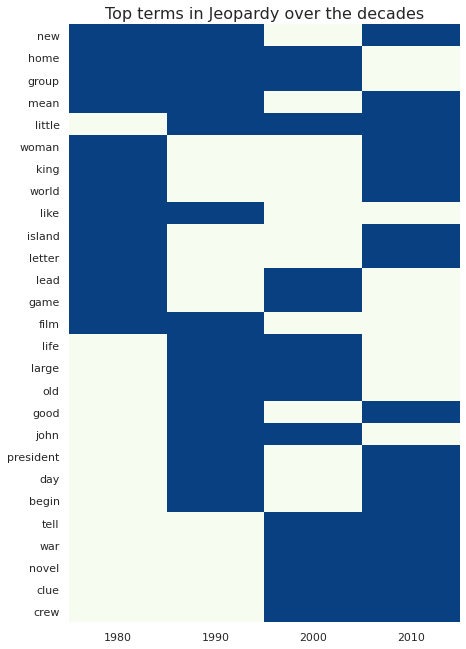

In [285]:
create_heatmap(topic_count_list, flat_1980, flat_1990, flat_2000, flat_2010, 'Jeopardy')

### 3.2.2 Trends in top Double Jeopardy terms
- The most popular Double Jeopardy terms that appeared in 3 of the 4 decades were write, woman, and sea
- There is a strong trend of terms that apeared only in the 2 most recent decades. There were 7 such terms, the most out of any round! These terms were clue, greek, art, crew, time, high, song

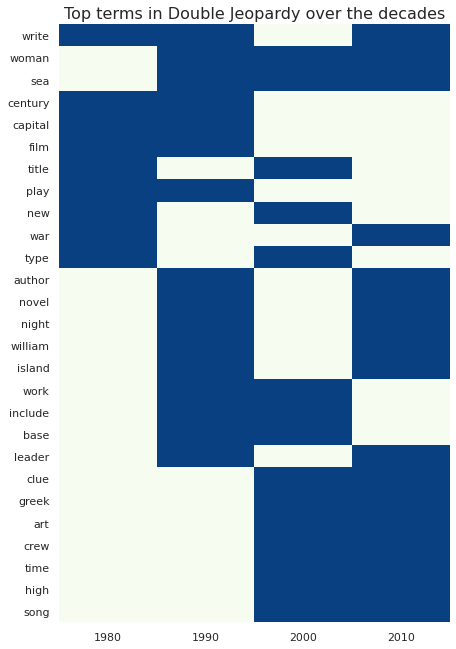

In [284]:
create_heatmap(dj_topic_count_list, dj_flat_1980, dj_flat_1990, dj_flat_2000, dj_flat_2010, 'Double Jeopardy')

## 3.2.3 Trends in top Final Jeopardy terms
- There is much more consistency in the top terms for Final Jeopardy across the decades. 
- Final Jeopardy was the only round that had terms that were present in all 4 decades! These terms were country, president, state, city, and year
- Once again, there is a clear trend of certain terms being present only in the 2 most recent decades. Those terms are letter, river, and come. 

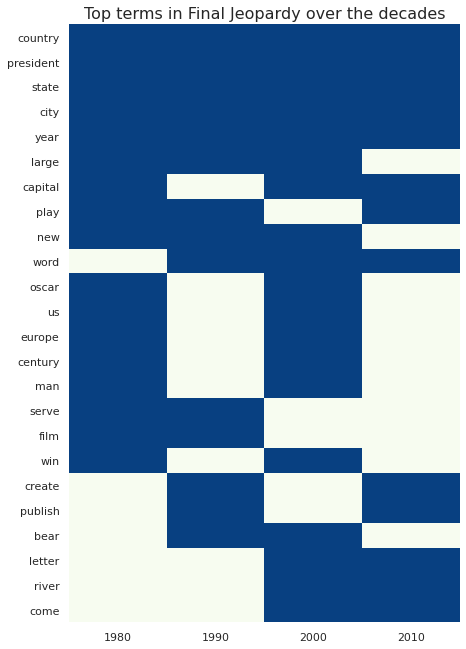

In [286]:
create_heatmap(fj_topic_count_list, fj_flat_1980, fj_flat_1990, fj_flat_2000, fj_flat_2010, 'Final Jeopardy')

In [237]:
df1 = pd.DataFrame({"Round":"Jeopardy!", "Terms":[x[1] for x in topic_count_list]})
df1['Count'] =  df1.groupby("Terms").transform('count')
df1.drop_duplicates(inplace=True)

df2 = pd.DataFrame({"Round":"Double Jeopardy!", "Terms":[x[1] for x in dj_topic_count_list]})
df2['Count'] =  df2.groupby("Terms").transform('count')
df2.drop_duplicates(inplace=True)

df3 = pd.DataFrame({"Round":"Final Jeopardy!", "Terms":[x[1] for x in fj_topic_count_list]})
df3['Count'] =  df3.groupby("Terms").transform('count')
df3.drop_duplicates(inplace=True)

df_final = pd.concat([df1, df2, df3])

### 3.2.4 Variation of topics in the 3 rounds
There are a few important things to note from the plot and word cloud below:
- Final Jeopardy was the only round that had terms that were present in all 4 decades. 
- The majority of terms appear in only one decade.
- It is very rare for topics to be repeated across decades. The top terms to describes themes tend to change throughout the decades. 
- The word clouds complement the trends that we see in the bar graphs. In Jeopardy and Double Jeopardy, there were only 3 terms that appeared in 3 decades and those terms are the largest in the word cloud. Final Jeopardy had 5 terms that appeared in all 4 decades, so we see those 5 words taking up the most space in the word cloud.  

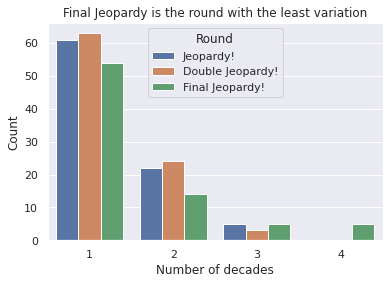

In [287]:
fig, ax = plt.subplots()
ax = sns.barplot(x = "Terms", y='Count', data=df_final, hue='Round')
ax.set_xlabel('Number of decades')
ax.set_title('Final Jeopardy is the round with the least variation')
plt.show()

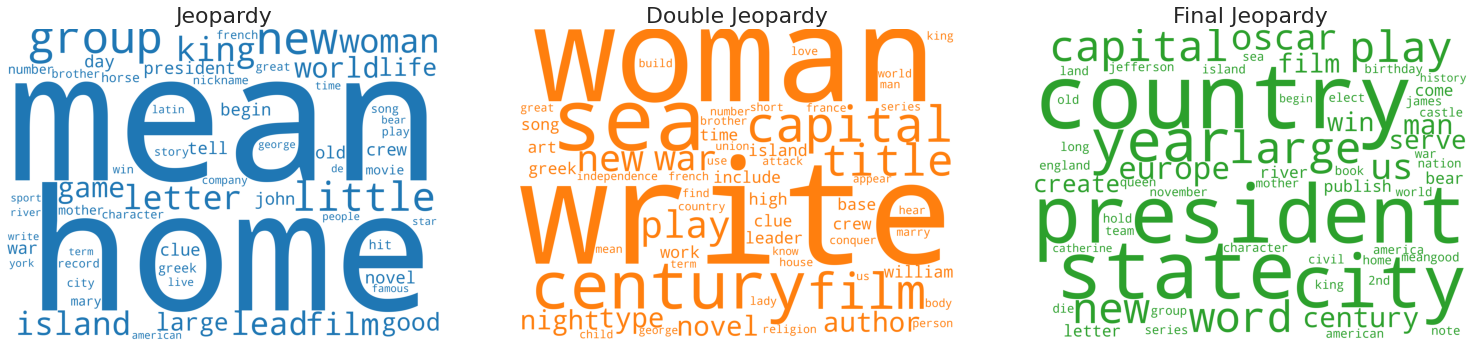

In [305]:
# Word cloud of top words 

j_all_decades = flat_1980 + flat_1990 + flat_2000 + flat_2010
dj_all_decades = dj_flat_1980 + dj_flat_1990 + dj_flat_2000 + dj_flat_2010
fj_all_decades = fj_flat_1980 + fj_flat_1990 + fj_flat_2000 + fj_flat_2010

all_decades = [j_all_decades, dj_all_decades, fj_all_decades]

round = ['Jeopardy', 'Double Jeopardy', 'Final Jeopardy']

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=60,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1,3, figsize=(22,5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)

    topic_words = " "
    topic_words = topic_words.join(all_decades[i])
    ax.set_title(round[i], fontsize=22)
    cloud.generate(topic_words)
    plt.gca().imshow(cloud)
    #plt.gca().set_title('Values Group' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

#axes[0].set_title("Jeopardy")
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# 4. Topic Modeling Approach 2: NMF 

Source for some of the code written in this section can be found here: https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

### 4.1 NMF Modeling Steps

### Data

In [291]:
# example year is 1989, later we will perform this process for all of the sample years
data_year = data[data['year'] == 1989]
data_year.head(1)

,category,air_date,question,value,answer,round,show_number,decade,month,year,Q_and_A
13726,"STARTS WITH ""KE""",1989-11-06,cooking pot ma pa,100.0,kettle,Jeopardy!,1191,1980,11,1989,cooking pot ma pa kettle


### Step 1: TFIDF

In [293]:
# documents for tfidf 
texts = data_year['Q_and_A']

tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2))
tfidf = tfidf_vectorizer.fit_transform(texts)

### Step 2: Choose Number of Topics 
we are selecting the number of components based on the previously calculated coherence score. Because the coherence score was calculated over game type and year we are take the average of the three game types to decide what number of categories to create for each year overall 

In [885]:
# reformatting optimal categories to get usable dataframe
yearly_optimal_categories = pd.read_csv("saved_optimal_categories.csv")
yearly_optimal_categories.columns = ["Jeopardy!", "Double Jeopardy!", "Final Jeopardy!"]
yearly_optimal_categories['Jeopardy!'] = yearly_optimal_categories.apply(lambda x: int((x['Jeopardy!'].rpartition("(")[2]).partition(",")[0]), axis=1)
yearly_optimal_categories['Double Jeopardy!'] = yearly_optimal_categories.apply(lambda x: int((x['Double Jeopardy!'].rpartition("(")[2]).partition(",")[0]), axis=1)
yearly_optimal_categories['Final Jeopardy!'] = yearly_optimal_categories.apply(lambda x: int((x['Final Jeopardy!'].rpartition("(")[2]).partition(",")[0]), axis=1)
yearly_optimal_categories['year'] = years

In [296]:
year_row = yearly_optimal_categories[yearly_optimal_categories['year'] == 1984].drop('year', axis=1)
optimal_num_topics = round(np.mean(year_row.values))

### Step 3: Fit NMF Model

In [308]:
nmf = NMF(
    n_components=optimal_num_topics,
    init='nndsvd').fit(tfidf)

### Step 4: Summarize Topics 

We are summarizing topics by taking the top five highest weighted words in each topic. Human intervention in the group labeling process may still be superior, but for efficiency this automatic way of selecting won out for us in this case (because there is a fairly high number of years and categories that are created in those years).

In [298]:
# words in tfidf matrix
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
feature_names = tfidf_feature_names

n_top_words = 10 # to see the 10 highest weighted words for each topic 
topic_word_weight_tracker = []
topic_word_tracker = []
for topic_idx, topic in enumerate(nmf.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    topic_word_weight_tracker.append(list(zip(top_features, weights)))
    topic_word_tracker.append(top_features)

In [299]:
# columns = ['topic']
# for i in range(10):
#     columns.append(f'topic_word_{i+1}')

In [300]:
columns = ['topic']
for i in range(10):
    columns.append(f'topic_word_{i+1}')

topic_df = pd.DataFrame(topic_word_tracker)
topic_df = topic_df.reset_index()
topic_df.columns = columns
topic_df.head()

,topic,topic_word_1,topic_word_2,topic_word_3,topic_word_4,topic_word_5,topic_word_6,topic_word_7,topic_word_8,topic_word_9,topic_word_10
0,0,wear,century,english,feature,kind,clothe,fancy,profession,leather,apron
1,1,city,chicago,city new,rome,wisconsin,washington dc,washington,leningrad,dc,populous
2,2,use,body,process,weave,flavor,algae,gas,cut,cook,metal
3,3,word,word mean,fancy,french word,greek,letter word,follow,shall,latin,greek word
4,4,new,york,new york,york city,city new,subway,early,system,boy,magazine


In [305]:
data_listed = data_year['Q_and_A'].tolist()

# creating dataframe of documents and their
# assigned topics 
docweights = nmf.transform(tfidf_vectorizer.transform(data_listed))
df_temp = pd.DataFrame({
    'document': data_listed,
    'topic_num': docweights.argmax(axis=1)
})

# Merging dataframes to get topic per document (i.e. per question)
merged_topic = df_temp.merge(
    topic_df,
    left_on='topic_num',
    right_on='topic',
    how='left'
)
merged_topic = merged_topic.drop('topic_num', axis=1)
merged_topic.head()

,document,topic,topic_word_1,topic_word_2,topic_word_3,topic_word_4,topic_word_5,topic_word_6,topic_word_7,topic_word_8,topic_word_9,topic_word_10
0,cooking pot ma pa kettle,0,wear,century,english,feature,kind,clothe,fancy,profession,leather,apron
1,bat hand serve wing,85,way,way mean,hang,lady,zeus,carry,flag,seed,cabinet,instrument
2,young vincent price play royal role broadway ...,11,play,broadway,1st play,role,produce,jean,crime,death,william,louis
3,bernard f law roger mahony john j oconnor cat...,20,john,henry,kennedy,lennon,sir,harry,john kennedy,death,rich,college
4,german mean flank horn wing horn use battle f...,2,use,body,process,weave,flavor,algae,gas,cut,cook,metal


In [285]:
# this is good - means we still have the correct number of documents 
len(merged_topic)

1179

### Step 5: Rank Topic Quality

We do this here by calculating the average residual for each topic. The topics with the lowest average residuals are considered the "best" fit topics according to this metric.

In [286]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

# calculating residuals for a given document
r = np.zeros(A.shape[0])
for document in range(A.shape[0]):
    r[document] = np.linalg.norm(A[document, :] - H[document, :].dot(W), 'fro')
    
# adding those residuals to the dataframe 
merged_topic['residuals'] = r

# Get the avg residual by topic
resid_data = merged_topic[[
    'topic',
    'residuals'
]].groupby('topic').mean().sort_values(by='residuals', ascending=True)

# no we have a way to rank the "top categories"
# i.e. the categories that have the lowest residuals 
top_10_topics = resid_data[:10]
merged_topic.head()

,document,topic,topic_word_1,topic_word_2,topic_word_3,topic_word_4,topic_word_5,topic_word_6,topic_word_7,topic_word_8,topic_word_9,topic_word_10,residuals
0,dc stand district columbia,82,movie,class,easy,bed,refer,title,peter,speak,johnny,newman,0.762995
1,color lucky letter day red,82,movie,class,easy,bed,refer,title,peter,speak,johnny,newman,0.540195
2,wheel head produce dairy checkout shopping cart,86,partner,hour,nick,comedy,thing,run,california,jame,astaire,actually,0.973979
3,variety include chinese dijon mustard,84,english,middle,language,sign,close,equivalent,2nd,speak,street,wind,0.753601
4,turn gang member box office star shirley temple,34,sea,red,jesus,special,water,road,level,foot,actually,netherlands,0.905323


### Step 6: Run Steps 1-5 For all years in our dataset 

In [306]:
year = 2000
data = data
def find_topics(year, data): 
    data_year = data[data['year'] == year]
    
    # Step 1: TFIDF 
    texts = data_year['Q_and_A']

    tfidf_vectorizer = TfidfVectorizer(
        min_df=3,
        max_df=0.85,
        max_features=5000,
        ngram_range=(1, 2))
    tfidf = tfidf_vectorizer.fit_transform(texts)
    
    # Step 2: Choose optimal number of topics (with coherence score)
    year_row = yearly_optimal_categories[yearly_optimal_categories['year'] == 1984].drop('year', axis=1)
    optimal_num_topics = round(np.mean(year_row.values))
    
    # Step 3: Fit NMF Model
    nmf = NMF(
    n_components=optimal_num_topics,
    init='nndsvd').fit(tfidf)
    
    # Step 4: Summarize the topics 
    # words in tfidf matrix
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    feature_names = tfidf_feature_names

    n_top_words = 10 # to see the 10 highest weighted words for each topic 
    topic_word_weight_tracker = []
    topic_word_tracker = []
    for topic_idx, topic in enumerate(nmf.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        topic_word_weight_tracker.append(list(zip(top_features, weights)))
        topic_word_tracker.append(top_features)
    
    columns = ['topic']
    for i in range(10):
        columns.append(f'topic_word_{i+1}')

    topic_df = pd.DataFrame(topic_word_tracker)
    topic_df = topic_df.reset_index()
    topic_df.columns = columns
    topic_df.head()
    
    data_listed = data_year['Q_and_A'].tolist()
    # creating dataframe of documents and their
    # assigned topics 
    docweights = nmf.transform(tfidf_vectorizer.transform(data_listed))
    df_temp = pd.DataFrame({
        'document': data_listed,
        'topic_num': docweights.argmax(axis=1)
    })

    # Merging dataframes to get topic per document (i.e. per question)
    merged_topic = df_temp.merge(
        topic_df,
        left_on='topic_num',
        right_on='topic',
        how='left')
    merged_topic = merged_topic.drop('topic_num', axis=1)

    # Step 5 Rank Topic Quality by calculating residuals 
    # Showing the 3 matrices we get witn nmf
    A = tfidf_vectorizer.transform(texts)
    W = nmf.components_
    H = nmf.transform(A)

    # calculating residuals for a given document
    r = np.zeros(A.shape[0])
    for document in range(A.shape[0]):
        r[document] = np.linalg.norm(A[document, :] - H[document, :].dot(W), 'fro')

    # adding those residuals to the dataframe 
    merged_topic['residuals'] = r

    # Get the avg residual by topic
    resid_data = merged_topic[[
        'topic',
        'residuals'
    ]].groupby('topic').mean().sort_values(by='residuals', ascending=True)

    # no we have a way to rank the "top categories"
    # i.e. the categories that have the lowest residuals 
    return merged_topic

In [317]:
for year in years:
    print(year)
    year_dataframe = find_topics(year, data)
    year_dataframe['year'] = year
    year_dataframe.to_csv(f"{year}_year_dataframe.csv", index=False)

## 4.2 Exploring Topic Meaning Over Time - with NMF 

We will be answering the following two questions: <br>
1. How similar are topic questions over time? 
2. How do the actual topics of the questions change over the years?

### 4.2.1 How similar are topic questions over time? 

In exploring this question we decided to examine the top ten words from the top ten categories (as ranked by residuals described above) of each year over time. This amounts to 100 words for each year. 

We first decided to see what proportion of words overlap from one year to the next. If you take a look at the first graph below you will see that an average of around 13% of the top ten words (in at least one of the top ten categories) matches a topic word from the previous year. This suggests that categories change over the years, but there is at least some overlap in topic from one year to the next.

We also decided to see how a single year's top category words relate to those of all other years. If you take a look at the second graph below you will see the graph for the year 1990. Interestingly, here the categories in year 1990 appear to be somewhat more related to previous years and less related to later years.

In [318]:
dataframes = []
for year in years:
    dataframes.append(f"{year}_df")

In [379]:
# top 10 categories in each year 
df_1984 = pd.read_csv("1984_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_1985 = pd.read_csv("1985_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_1986 = pd.read_csv("1986_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_1987 = pd.read_csv("1987_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_1988 = pd.read_csv("1988_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_1989 = pd.read_csv("1989_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_1990 = pd.read_csv("1990_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_1991 = pd.read_csv("1991_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_1992 = pd.read_csv("1992_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_1993 = pd.read_csv("1993_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_1994 = pd.read_csv("1994_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_1995 = pd.read_csv("1995_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_1996 = pd.read_csv("1996_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_1997 = pd.read_csv("1997_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_1998 = pd.read_csv("1998_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_1999 = pd.read_csv("1999_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_2000 = pd.read_csv("2000_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_2001 = pd.read_csv("2001_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_2002 = pd.read_csv("2002_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_2003 = pd.read_csv("2003_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_2004 = pd.read_csv("2004_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_2005 = pd.read_csv("2005_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_2006 = pd.read_csv("2006_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_2007 = pd.read_csv("2007_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_2008 = pd.read_csv("2008_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_2009 = pd.read_csv("2009_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_2010 = pd.read_csv("2010_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]; df_2011 = pd.read_csv("2011_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]
df_2012 = pd.read_csv("2012_year_dataframe.csv").sort_values(['residuals'], ascending=True).drop_duplicates(['topic'])[:10]

In [811]:
main_df = pd.concat([df_2012,df_2011,df_2010,df_2009,df_2008,df_2007,df_2006,df_2005,df_2004,df_2003,df_2002,df_2001,df_2000,df_1999,df_1998,df_1997,df_1996,df_1995,df_1994,df_1993,df_1992,df_1991,df_1990,df_1989,df_1988,df_1987,df_1986,df_1985,df_1984])
dataframes = [df_2012,df_2011,df_2010,df_2009,df_2008,df_2007,df_2006,df_2005,df_2004,df_2003,df_2002,df_2001,df_2000,df_1999,df_1998,df_1997,df_1996,df_1995,df_1994,df_1993,df_1992,df_1991,df_1990,df_1989,df_1988,df_1987,df_1986,df_1995,df_1984]

In [812]:
topics_only = main_df[['topic', 'year', 'topic_word_1', 'topic_word_2', 'topic_word_3', 'topic_word_4', 'topic_word_5', 'topic_word_6', 'topic_word_7', 'topic_word_8', 'topic_word_9', 'topic_word_10']]

In [813]:
def get_topics(row):
    word_list = []
    for i in range(10):
        word_list.append(row[f'topic_word_{i+1}'])
    return word_list

In [814]:
# dictionary with key: top words per year 
# 29 years and 100 words per year 
yearly_words = {}
for year, dataframe in zip(years, dataframes):
    word_list = dataframe.apply(lambda row: get_topics(row), axis=1)
    word_list = list(itertools.chain.from_iterable(word_list))
    yearly_words[year] = word_list

In [815]:
matches_tracker = []
for key, value in yearly_words.items():
    temp_dict = yearly_words.copy()
    # selecting current year's words
    current_words = temp_dict.pop(key)
    # looping through all years excluding current year
    for k, v in temp_dict.items():
        # comparing current year's words with words of every other year
        for word in current_words:
            for w in v:
                if word == w:
                    # tracking original year and year it matches with 
                    matches_tracker.append((word, key, k))

In [816]:
# there will be duplicates I believe
matches_df = pd.DataFrame(matches_tracker)
matches_df.columns = ['word', 'original_year', 'matching_year']

In [817]:
# how many matches the original_year has with each other year
grouped_matches_df = matches_df.groupby(by=['original_year', 'matching_year'], dropna=False).count()
grouped_matches_df = grouped_matches_df.reset_index()

In [818]:
# finding the number of matching words with the previous words (the represents the total matches out of a possible 100)
tracking_dict = {}
for index, row in grouped_matches_df.iterrows():
    if row['matching_year'] == row['original_year'] + 1:
        tracking_dict[row['matching_year']] = (row['word'] / 100)

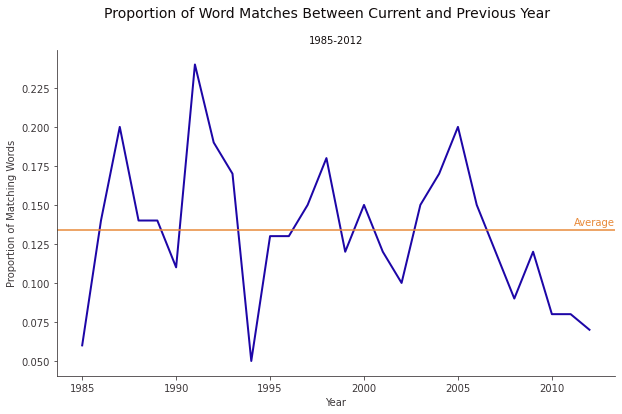

In [819]:
# number of word matches between current year and previous year
fig, ax = plt.subplots(figsize=(10,6)) 

ax.plot(tracking_dict.keys(), tracking_dict.values(), linewidth=2, color= '#1d06a7')
plt.axline((1985, np.average(list(tracking_dict.values()))), (2012, np.average(list(tracking_dict.values()))), color='#e88938')
plt.text(2011.19, 0.137, 'Average', color='#e88938')

# visualization details
plt.suptitle("Proportion of Word Matches Between Current and Previous Year", fontsize = 14, color='#110c0c')
plt.title("1985-2012", color='#110c0c', fontsize = 10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#3d383a')
ax.spines['bottom'].set_color('#3d383a')
ax.set_xlabel("Year", color='#3d383a')
ax.set_ylabel("Proportion of Matching Words", color='#3d383a')
ax.tick_params(axis='x', colors='#3d383a')   
ax.tick_params(axis='y', colors='#3d383a') 
plt.show()

<ipython-input-884-01fc6fe8381d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_with_1990['proportion_possible_matches'] = matches_with_1990['word'] / 100


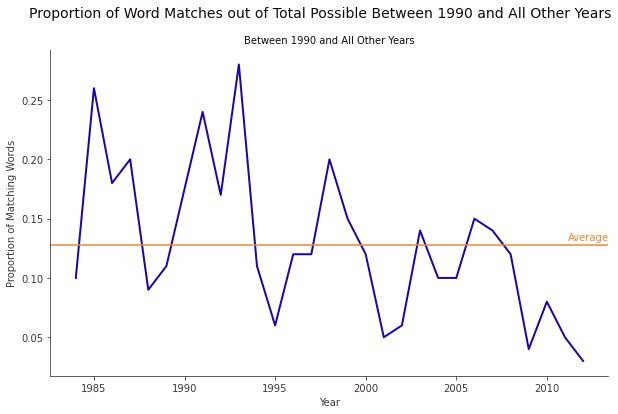

In [884]:
matches_with_1990 = grouped_matches_df[grouped_matches_df['original_year'] == 1990]
matches_with_1990['proportion_possible_matches'] = matches_with_1990['word'] / 100

# number of word matches between the year 2000 and all other years 
fig, ax = plt.subplots(figsize=(10,6))  # make one subplot (ax) on the figure
ax.plot(matches_with_1990['matching_year'], matches_with_1990['proportion_possible_matches'], linewidth=2, color='#1d06a7')
plt.axline((1985, np.average(list(matches_with_1990['proportion_possible_matches'].values))), (2012, np.average(list(matches_with_1990['proportion_possible_matches'].values))), color='#e88938')
plt.text(2011.19, 0.1315, 'Average', color='#e88938')


# visualization details
plt.title("Between 1990 and All Other Years", color='#110c0c', fontsize = 10)
plt.suptitle("Proportion of Word Matches out of Total Possible Between 1990 and All Other Years", color='#110c0c', fontsize = 14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#3d383a')
ax.spines['bottom'].set_color('#3d383a')
ax.set_xlabel("Year", color='#3d383a')
ax.set_ylabel("Proportion of Matching Words", color='#3d383a')
ax.tick_params(axis='x', colors='#3d383a')   
ax.tick_params(axis='y', colors='#3d383a') 
plt.show()

### 4.2.2 How do the actual topics of the questions change over the years?

This question was especially difficult to answer because it is difficult to get a clear English label for each topic. In this specific analysis we decided to hand label each topic in each year with a "plain" English label based on the top ten words in each topic. This was a difficult task because some of the categories were seemingly random. (Disclaimer - these hand labeled topics are not scientific, no codebook was created to classify topics and the data contains a significant amount of noise. These categories are meant to be a first exploration and should not be used to draw conclusions.)

Nevertheless, some interesting insights can be gleaned from these labeled topics. First that there are topics that appear to show up consistently across all years of gameplay. As you can see from the wordclouds below topics regarding  word meaning, animals, art/theatre, etc. consistently show up overtime. However, anecdotally, it looks like topics have gotten less US focused over the years.  

In [878]:
topics_2012 = ['new york', 'food and drink', 'people', 'literature', 'politics', 'animals', 'sounds', 'ocean', 'animals', 'movies or media']
topics_2011 = ['literature', 'people', 'languages', 'sports', 'geography', 'music', 'animals', 'religion', 'literature', 'grammar']
topics_2010 = ['crime', 'grammar', 'food', 'holidays', 'grammar', 'history', 'language', 'literature', 'history', 'poetry']
topics_2009 = ['literature', 'nature', 'famous people', 'animals', 'media', 'history', 'word origin', 'animals', 'grammar', 'military']
topics_2008 = ['world wars', 'literature', 'geography', 'animals', 'currency', 'theatre', 'word origin', 'time', 'US History', 'geography']
topics_2007 = ['legal', 'education', 'technology', 'word meaning', 'crime', 'geography', 'famous people', 'geography', 'medicine', 'literature']
topics_2006 = ['literature', 'people', 'europe', 'media', 'word meaning', 'poetry', 'holidays', 'word origin', 'life', 'grammar']
topics_2005 = ['people', 'plants', 'animals', 'media', 'animals', 'US History', 'word meaning', 'time', 'similarities', 'language']
topics_2004 = ['people', 'language', 'animals', 'word meaning', 'word origin', 'French', 'bears', 'baseball', 'books', 'grammar']
topics_2003 = ['boy', 'maps', 'word origin', 'plants', 'word meaning', 'countries', 'actors', 'life', 'measurements', 'religion']
topics_2002 = ['clue', 'men and women', 'known', 'large', 'women', 'History', 'Film', 'actors', 'similarities', 'animals']
topics_2001 = ['legal', 'known', 'religion', 'cities', 'plants', 'women', 'language', 'years/time', 'artists', 'distances']
topics_2000 = ['nations', 'maps', 'men and women', 'word meaning', 'animals', 'space', 'famous people', 'women', 'geography', 'numbers']
topics_1999 = ['sports', 'language', 'similarities', 'word meaning', 'europe', 'word origin', 'time', 'years/time', 'love', 'geography/cluture']
topics_1998 = ['acting', 'country', 'word meaning', 'terms', 'power', 'cities', 'animals', 'greek', 'media', 'love']
topics_1997 = ['college', 'geography', 'word meaning', 'cities', 'religion', 'elements', 'cities', 'countries', 'art and France', 'holidays']
topics_1996 = ['cities', 'instruments', 'politics', 'time', 'europe', 'material', 'art', 'animals', 'love', 'geography/cluture']
topics_1995 = ['cities', 'outdoors', 'geography', 'royalty', 'territory', 'capitals', 'famous people', 'technology', 'color', 'people']
topics_1994 = ['cities', 'people', 'world', 'monarchy', 'devices', 'places', 'US History', 'religion', 'geography', 'theatre']
topics_1993 = ['capitals', 'music', 'food', 'countries', 'money', 'actors', 'people', 'religion', 'words', 'war']
topics_1992 = ['US cities', 'language', 'words', 'theatre', 'countries', 'US States', 'US History', 'people', 'animals', 'war']
topics_1991 = ['cities', 'history', 'Historic people', 'world geography', 'leaders', 'people', 'animals', 'games', 'US History', 'US cities']
topics_1990 = ['literature', 'cities', 'word meaning', 'world history', 'time', 'tools', 'world', 'countries', 'best', 'word meaning']
topics_1989 = ['music', 'books', 'activities', 'art', 'devices', 'people', 'actors', 'word meaning', 'new york', 'US cities']
topics_1988 = ['US states', 'animals', 'theatre', 'numbers', 'military', 'world geography', 'literature', 'countries', 'inventions', 'places']
topics_1987 = ['US History', 'people', 'sports', 'US presidents', 'characters', 'actors', 'tools', 'years', 'geography', 'languages']
topics_1986 = ['US presidents', 'men', 'sports', 'US history', 'characters', 'war', 'tools', 'year', 'capitals', 'languages']
topics_1985 = ['cities', 'technology', 'tools', 'places', 'language', 'art', 'history', 'medicine', 'literature', 'places']
topics_1984 = ['geography', 'places', 'numbers', 'music', 'words', 'people', 'long', 'theatre', 'words', 'world geography']

In [879]:
topics_1991_dict = dict()
for word in topics_1991:
    topics_1991_dict[word] = 1

In [880]:
word_cloud_lists = [topics_2012_dict, topics_2009_dict, topics_2006_dict, topics_2003_dict, topics_2000_dict, topics_1997_dict, topics_1994_dict, topics_1991_dict, topics_1988_dict, topics_1985_dict]

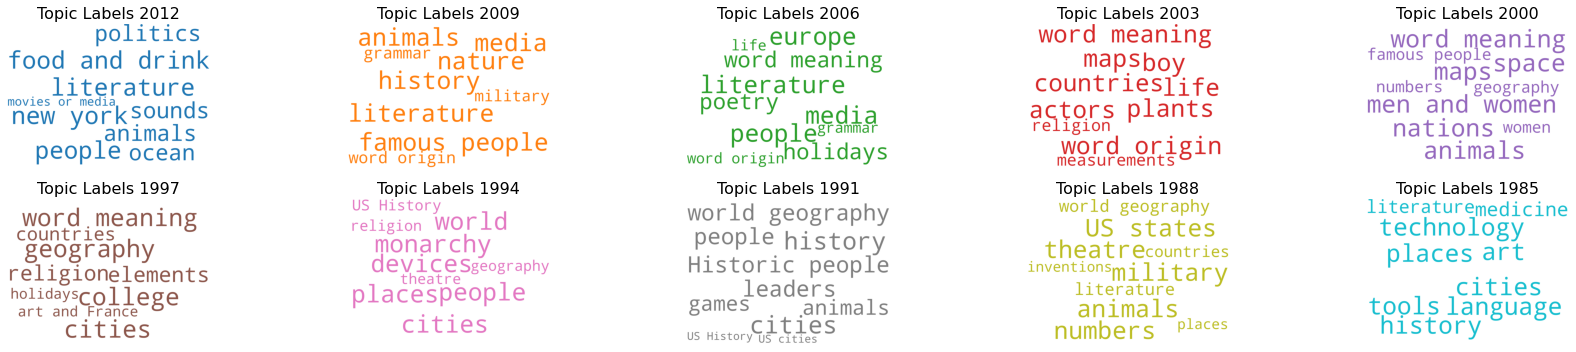

In [882]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=60,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

# topics = lda_model.show_topics(formatted=False)


fig, axes = plt.subplots(2,5, figsize=(25,5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    # topic_words = dict(topics[i][1])
    
    topic_words = word_cloud_lists[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(f"Topic Labels {(2012 - (i*3))}", fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bfaa4a20-d653-408a-9d61-32ce380046ea' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>